# BERT相关笔记

## 14.8. 来自Transformers的双向编码器表示（BERT）

### 14.8.3. BERT：把两个最好的结合起来

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

### 14.8.4. 输入表示
在自然语言处理中，有些任务（如情感分析）以单个文本作为输入，而有些任务（如自然语言推断）以一对文本序列作为输入。BERT输入序列明确地表示单个文本和文本对。当输入为单个文本时，BERT输入序列是特殊类别词元“<cls>”、文本序列的标记、以及特殊分隔词元“<sep>”的连结。当输入为文本对时，BERT输入序列是“<cls>”、第一个文本序列的标记、“<sep>”、第二个文本序列标记、以及“<sep>”的连结。我们将始终如一地将术语“BERT输入序列”与其他类型的“序列”区分开来。例如，一个BERT输入序列可以包括一个文本序列或两个文本序列。

In [2]:
#@save
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """获取输入序列的词元及其片段索引"""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0和1分别标记片段A和B
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

BERT选择Transformer编码器作为其双向架构。在Transformer编码器中常见是，位置嵌入被加入到输入序列的每个位置。然而，与原始的Transformer编码器不同，BERT使用可学习的位置嵌入。

与TransformerEncoder不同，BERTEncoder使用片段嵌入和可学习的位置嵌入。

In [3]:
#@save
class BERTEncoder(nn.Module):
    """BERT编码器"""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(f"{i}", d2l.EncoderBlock(
                key_size, query_size, value_size, num_hiddens, norm_shape,
                ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
        # 在BERT中，位置嵌入是可学习的，因此我们创建一个足够长的位置嵌入参数
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # 在以下代码段中，X的形状保持不变：（批量大小，最大序列长度，num_hiddens）
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

假设词表大小为10000，为了演示BERTEncoder的前向推断，让我们创建一个实例并初始化它的参数。

In [4]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input,
                      ffn_num_hiddens, num_heads, num_layers, dropout)

In [5]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
tokens.shape, segments.shape, encoded_X.shape

(torch.Size([2, 8]), torch.Size([2, 8]), torch.Size([2, 8, 768]))

### 14.8.5. 预训练任务

BERTEncoder的前向推断给出了输入文本的每个词元和插入的特殊标记“<cls>”及“<seq>”的BERT表示。接下来，我们将使用这些表示来计算预训练BERT的损失函数。预训练包括以下两个任务：掩蔽语言模型和下一句预测。

#### 14.8.5.1. 掩蔽语言模型（Masked Language Modeling）

为了双向编码上下文以表示每个词元，BERT随机掩蔽词元并使用来自双向上下文的词元以自监督的方式预测掩蔽词元。此任务称为掩蔽语言模型。

在这个预训练任务中，将随机选择15%的词元作为预测的掩蔽词元。要预测一个掩蔽词元而不使用标签作弊，一个简单的方法是总是用一个特殊的“<mask>”替换输入序列中的词元。然而，人造特殊词元“<mask>”不会出现在微调中。为了避免预训练和微调之间的这种不匹配，如果为预测而屏蔽词元（例如，在“this movie is great”中选择掩蔽和预测“great”），则在输入中将其替换为：

- 80%时间为特殊的“<mask>“词元（例如，“this movie is great”变为“this movie is<mask>”；

- 10%时间为随机词元（例如，“this movie is great”变为“this movie is drink”）；

- 10%时间内为不变的标签词元（例如，“this movie is great”变为“this movie is great”）。

我们实现了下面的MaskLM类来预测BERT预训练的掩蔽语言模型任务中的掩蔽标记。预测使用单隐藏层的多层感知机（self.mlp）。在前向推断中，它需要两个输入：BERTEncoder的编码结果和用于预测的词元位置。输出是这些位置的预测结果。

In [6]:
#@save
class MaskLM(nn.Module):
    """BERT的掩蔽语言模型任务"""
    def __init__(self, vocab_size, num_hiddens, num_inputs=768, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.Linear(num_inputs, num_hiddens),
                                 nn.ReLU(),  # 也可以使用GELU
                                 nn.LayerNorm(num_hiddens),
                                 nn.Linear(num_hiddens, vocab_size))

    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # 假设batch_size=2，num_pred_positions=3
        # 那么batch_idx是np.array（[0,0,0,1,1,1]）
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

In [7]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [8]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

torch.Size([6])

#### 14.8.5.2. 下一句预测（Next Sentence Prediction）

In [9]:
#@save
class NextSentencePred(nn.Module):
    """BERT的下一句预测任务"""
    def __init__(self, num_inputs, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.Linear(num_inputs, 2)

    def forward(self, X):
        # X的形状：(batchsize,num_hiddens)
        return self.output(X)

In [10]:
encoded_X = torch.flatten(encoded_X, start_dim=1)
# NSP的输入形状:(batchsize，num_hiddens)
nsp = NextSentencePred(encoded_X.shape[-1])
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape, encoded_X.shape

(torch.Size([2, 2]), torch.Size([2, 6144]))

In [11]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

### 14.8.6. 整合代码

在预训练BERT时，最终的损失函数是掩蔽语言模型损失函数和下一句预测损失函数的线性组合。现在我们可以通过实例化三个类BERTEncoder、MaskLM和NextSentencePred来定义BERTModel类。前向推断返回编码后的BERT表示encoded_X、掩蔽语言模型预测mlm_Y_hat和下一句预测nsp_Y_hat。

In [12]:
#@save
class BERTModel(nn.Module):
    """BERT模型"""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 hid_in_features=768, mlm_in_features=768,
                 nsp_in_features=768):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape,
                    ffn_num_input, ffn_num_hiddens, num_heads, num_layers,
                    dropout, max_len=max_len, key_size=key_size,
                    query_size=query_size, value_size=value_size)
        self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens, mlm_in_features)
        self.nsp = NextSentencePred(nsp_in_features)

    def forward(self, tokens, segments, valid_lens=None,
                pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # 用于下一句预测的多层感知机分类器的隐藏层，0是“<cls>”标记的索引
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

## 14.9. 用于预训练BERT的数据集

为了预训练 14.8节中实现的BERT模型，我们需要以理想的格式生成数据集，以便于两个预训练任务：遮蔽语言模型和下一句预测。一方面，最初的BERT模型是在两个庞大的图书语料库和英语维基百科（参见 14.8.5节）的合集上预训练的，但它很难吸引这本书的大多数读者。另一方面，现成的预训练BERT模型可能不适合医学等特定领域的应用。因此，在定制的数据集上对BERT进行预训练变得越来越流行。为了方便BERT预训练的演示，我们使用了较小的语料库WikiText-2 (Merity et al., 2016)。

与 14.3节中用于预训练word2vec的PTB数据集相比，WikiText-2（1）保留了原来的标点符号，适合于下一句预测；（2）保留了原来的大小写和数字；（3）大了一倍以上。

In [13]:
import os
import random
import torch
from d2l import torch as d2l

在WikiText-2数据集中，每行代表一个段落，其中在任意标点符号及其前面的词元之间插入空格。保留至少有两句话的段落。为了简单起见，我们仅使用句号作为分隔符来拆分句子。我们将更复杂的句子拆分技术的讨论留在本节末尾的练习中。

In [14]:
#@save
d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

#@save
def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r') as f:
        lines = f.readlines()
    # 大写字母转换为小写字母
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

### 14.9.1. 为预训练任务定义辅助函数

在下文中，我们首先为BERT的两个预训练任务实现辅助函数。这些辅助函数将在稍后将原始文本语料库转换为理想格式的数据集时调用，以预训练BERT。

#### 14.9.1.1. 生成下一句预测任务的数据

_get_next_sentence函数生成二分类任务的训练样本。

In [15]:
#@save
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        # paragraphs是三重列表的嵌套
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

下面的函数通过调用_get_next_sentence函数从输入paragraph生成用于下一句预测的训练样本。这里paragraph是句子列表，其中每个句子都是词元列表。自变量max_len指定预训练期间的BERT输入序列的最大长度。

In [16]:
#@save
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        # 下面的3，考虑1个'<cls>'词元和2个'<sep>'词元
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph

#### 14.9.1.2. 生成遮蔽语言模型任务的数据

为了从BERT输入序列生成遮蔽语言模型的训练样本，我们定义了以下_replace_mlm_tokens函数。在其输入中，tokens是表示BERT输入序列的词元的列表，candidate_pred_positions是不包括特殊词元的BERT输入序列的词元索引的列表（特殊词元在遮蔽语言模型任务中不被预测），以及num_mlm_preds指示预测的数量（选择15%要预测的随机词元）。在 14.8.5.1节中定义遮蔽语言模型任务之后，在每个预测位置，输入可以由特殊的“掩码”词元或随机词元替换，或者保持不变。最后，该函数返回可能替换后的输入词元、发生预测的词元索引和这些预测的标签。

In [17]:
#@save
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds,
                        vocab):
    # 为遮蔽语言模型的输入创建新的词元副本，其中输入可能包含替换的“<mask>”或随机词元
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    # 打乱后用于在遮蔽语言模型任务中获取15%的随机词元进行预测
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        # 80%的时间：将词替换为“<mask>”词元
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10%的时间：保持词不变
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10%的时间：用随机词替换该词
            else:
                masked_token = random.choice(vocab.idx_to_token)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels

通过调用前述的_replace_mlm_tokens函数，以下函数将BERT输入序列（tokens）作为输入，并返回输入词元的索引（在 14.8.5.1节中描述的可能的词元替换之后）、发生预测的词元索引以及这些预测的标签索引。

In [18]:
#@save
def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    # tokens是一个字符串列表
    for i, token in enumerate(tokens):
        # 在遮蔽语言模型任务中不会预测特殊词元
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    # 遮蔽语言模型任务中预测15%的随机词元
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                       key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

### 14.9.2. 将文本转换为预训练数据集

现在我们几乎准备好为BERT预训练定制一个Dataset类。在此之前，我们仍然需要定义辅助函数_pad_bert_inputs来将特殊的“<mask>”词元附加到输入。它的参数examples包含来自两个预训练任务的辅助函数_get_nsp_data_from_paragraph和_get_mlm_data_from_tokens的输出。

In [19]:
#@save
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens,  = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments,
         is_next) in examples:
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0] * (
            max_len - len(segments)), dtype=torch.long))
        # valid_lens不包括'<pad>'的计数
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        # 填充词元的预测将通过乘以0权重在损失中过滤掉
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(pred_positions)),
                dtype=torch.float32))
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (
            max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)

将用于生成两个预训练任务的训练样本的辅助函数和用于填充输入的辅助函数放在一起，我们定义以下_WikiTextDataset类为用于预训练BERT的WikiText-2数据集。通过实现__getitem__函数，我们可以任意访问WikiText-2语料库的一对句子生成的预训练样本（遮蔽语言模型和下一句预测）样本。

最初的BERT模型使用词表大小为30000的WordPiece嵌入 (Wu et al., 2016)。WordPiece的词元化方法是对 14.6.2节中原有的字节对编码算法稍作修改。为简单起见，我们使用d2l.tokenize函数进行词元化。出现次数少于5次的不频繁词元将被过滤掉。

In [20]:
#@save
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        # 输入paragraphs[i]是代表段落的句子字符串列表；
        # 而输出paragraphs[i]是代表段落的句子列表，其中每个句子都是词元列表
        paragraphs = [d2l.tokenize(
            paragraph, token='word') for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs
                     for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=[
            '<pad>', '<mask>', '<cls>', '<sep>'])
        # 获取下一句子预测任务的数据
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len))
        # 获取遮蔽语言模型任务的数据
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                      + (segments, is_next))
                     for tokens, segments, is_next in examples]
        # 填充输入
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
            examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])

    def __len__(self):
        return len(self.all_token_ids)

通过使用_read_wiki函数和_WikiTextDataset类，我们定义了下面的load_data_wiki来下载并生成WikiText-2数据集，并从中生成预训练样本。

In [21]:
#@save
def load_data_wiki(batch_size, max_len):
    """加载WikiText-2数据集"""
    # data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    data_dir = r'.\wikitext-2-v1\wikitext-2//'
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
    return train_iter, train_set.vocab

In [22]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

# 显示迭代器其中一次的输出结果
for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
          nsp_y.shape)
    break

torch.Size([512, 64]) torch.Size([512, 64]) torch.Size([512]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512])


In [23]:
len(vocab)

20256

## 14.10. 预训练BERT

In [24]:
import torch
from torch import nn
from d2l import torch as d2l

In [25]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

了便于演示，我们定义了一个小的BERT，使用了2层、128个隐藏单元和2个自注意头。

In [26]:
net = d2l.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()
devices

[device(type='cuda', index=0)]

在定义训练代码实现之前，我们定义了一个辅助函数_get_batch_loss_bert。给定训练样本，该函数计算遮蔽语言模型和下一句子预测任务的损失。请注意，BERT预训练的最终损失是遮蔽语言模型损失和下一句预测损失的和。

In [27]:
#@save
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # 前向传播
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # 计算遮蔽语言模型损失
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # 计算下一句子预测任务的损失
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

通过调用上述两个辅助函数，下面的train_bert函数定义了在WikiText-2（train_iter）数据集上预训练BERT（net）的过程。训练BERT可能需要很长时间。以下函数的输入num_steps指定了训练的迭代步数，而不是像train_ch13函数那样指定训练的轮数（参见 13.1节）。

In [28]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # 遮蔽语言模型损失的和，下一句预测任务损失的和，句子对的数量，计数
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

在预训练过程中，我们可以绘制出遮蔽语言模型损失和下一句预测损失。

MLM loss 5.387, NSP loss 0.740
6566.8 sentence pairs/sec on [device(type='cuda', index=0)]


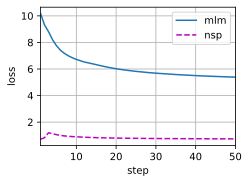

In [29]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

### 14.10.2. 用BERT表示文本

在预训练BERT之后，我们可以用它来表示单个文本、文本对或其中的任何词元。下面的函数返回tokens_a和tokens_b中所有词元的BERT（net）表示。

In [30]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

考虑“a crane is flying”这句话。回想一下 14.8.4节中讨论的BERT的输入表示。插入特殊标记“<cls>”（用于分类）和“<sep>”（用于分隔）后，BERT输入序列的长度为6。因为零是“<cls>”词元，encoded_text[:, 0, :]是整个输入语句的BERT表示。为了评估一词多义词元“crane”，我们还打印出了该词元的BERT表示的前三个元素。

In [31]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# 词元-长度为6：'<cls>','a','crane','is','flying','<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([-0.0647, -1.2255, -0.4086], device='cuda:0', grad_fn=<SliceBackward0>))

现在考虑一个句子“a crane driver came”和“he just left”。类似地，encoded_pair[:, 0, :]是来自预训练BERT的整个句子对的编码结果。注意，多义词元“crane”的前三个元素与上下文不同时的元素不同。这支持了BERT表示是上下文敏感的。

In [32]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# 词元-长度为10：'<cls>','a','crane','driver','came','<sep>','he','just', 'left','<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([-0.1118, -1.3486, -0.3907], device='cuda:0', grad_fn=<SliceBackward0>))